In [3]:
import numpy as np
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot
import six.moves.cPickle as pickle
import gzip
import os
import sys
from sklearn.preprocessing import MinMaxScaler

###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        self.lamda = lamda                  # weight decay parameter
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1)
        
        rand = np.random.RandomState(int(time.time()))
        
        W1 = np.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = np.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = np.zeros((hidden_size, 1))
        b2 = np.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """

        self.theta = np.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + np.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        
        hidden_layer = self.sigmoid(np.dot(W1, input) + b1)
        output_layer = self.sigmoid(np.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = np.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input
        
        sum_of_squares_error = 0.5 * np.sum(np.multiply(diff, diff)) / input.shape[1]
        weight_decay         = 0.5 * self.lamda * (np.sum(np.multiply(W1, W1)) +
                                                   np.sum(np.multiply(W2, W2)))
        KL_divergence        = self.beta * np.sum(self.rho * np.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * np.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        
        del_out = np.multiply(diff, np.multiply(output_layer, 1 - output_layer))
        del_hid = np.multiply(np.dot(np.transpose(W2), del_out) + np.transpose(np.matrix(KL_div_grad)), 
                                 np.multiply(hidden_layer, 1 - hidden_layer))
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = np.dot(del_hid, np.transpose(input))
        W2_grad = np.dot(del_out, np.transpose(hidden_layer))
        b1_grad = np.sum(del_hid, axis = 1)
        b2_grad = np.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = np.array(W1_grad)
        W2_grad = np.array(W2_grad)
        b1_grad = np.array(b1_grad)
        b2_grad = np.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = np.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]


""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side),
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()


def executeSparseAutoencoder(training_data):

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = 28      # side length of sampled image patches
    hid_patch_side = 8     # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = 10000  # number of training examples
    max_iterations = 250   # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
   
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations,'disp': True})
    opt_theta = opt_solution.x
    opt_W1 = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    opt_W2 = opt_theta[encoder.limit1 : encoder.limit2].reshape(visible_size, hidden_size)
    opt_b1 = opt_theta[encoder.limit2 : encoder.limit3].reshape(hidden_size, 1)
    opt_b2 = opt_theta[encoder.limit3 : encoder.limit4].reshape(visible_size, 1)
    """ Visualize the obtained optimal W1 weights """
    compressedInputs= encoder.sigmoid(numpy.dot(opt_W1, training_data) + opt_b1)
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)
    return opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs

def executeMain(training_data):
    opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeSparseAutoencoder(training_data)
    return opt_W1,opt_W2,opt_b1,opt_b2,np.transpose(compressedInputs)

In [4]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

(50000,)


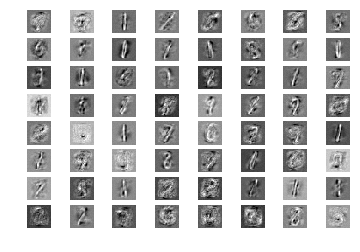

"n_models=n_classes\nminibatch_size = 100\nn_hidden=100\nn_planes=4\nn_iter = 600\nlr=0.005\nprint(n_classes)\nmodel=[]\nfor k in range(n_models):\n    # create models\n    #odel[k] = make_network(n_hidden,n_planes,n_feature)\n    model.append(make_network(n_hidden,n_planes,n_feature))\n\n\nmodel = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)\n\n\ny_pred = np.zeros_like(y_test)\n\nfor i, x in enumerate(X_test):\n    y = np.ones((n_models,))\n    for index, indmodel in enumerate(model, start=0): \n        oop,iop,hop = forward(x, indmodel)\n        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))\n        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()\n    \n    y_pred[i] = y.argmin()\n\n# Compare the predictions with the true labels and take the percentage\naccs= (y_pred == y_test).sum() / y_test.size\n\n\ncnf_matrix = confusion_matrix(y_test, y_pred)\n#print(cnf_matrix)\nplt.figure()

In [5]:
###### eigenbag ###########
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os



with gzip.open('mnist.pkl.gz', 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)
X_train, y_train = train_set
X_test, y_test = test_set
X_Val, y_Val = valid_set  
print(y_train.shape)
scaler = MinMaxScaler(copy=True, feature_range=(0.1, 0.9))
scaler.fit(X_train)
dataset=scaler.transform(X_train)

opt_W1,opt_W2,opt_b1,opt_b2,compressedInputs=executeMain(np.transpose(dataset))


        
'''n_models=n_classes
minibatch_size = 100
n_hidden=100
n_planes=4
n_iter = 600
lr=0.005
print(n_classes)
model=[]
for k in range(n_models):
    # create models
    #odel[k] = make_network(n_hidden,n_planes,n_feature)
    model.append(make_network(n_hidden,n_planes,n_feature))


model = sgd(model, X_train, y_train, minibatch_size,n_planes,n_models,n_hidden,n_iter,X_Val,y_Val,X_test,y_test,n_classes,lr)


y_pred = np.zeros_like(y_test)

for i, x in enumerate(X_test):
    y = np.ones((n_models,))
    for index, indmodel in enumerate(model, start=0): 
        oop,iop,hop = forward(x, indmodel)
        val=(np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))
        y[index]= ((np.absolute(iop)/ LA.norm(indmodel['W2'], axis=0))).min()
    
    y_pred[i] = y.argmin()

# Compare the predictions with the true labels and take the percentage
accs= (y_pred == y_test).sum() / y_test.size


cnf_matrix = confusion_matrix(y_test, y_pred)
#print(cnf_matrix)
plt.figure()
plot_confusion_matrix(cnf_matrix,n_classes, normalize=False,
                      title='confusion matrix')

plt.show()
print('Test  accuracy: {}'.format(accs))'''

In [7]:
from itertools import combinations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy.matlib
from sklearn.metrics import f1_score
import six.moves.cPickle as pickle
import gzip
import os

n_feature=dataset.shape[1]

if np.amin(y_train)==0:
    n_classes=int(np.amax(y_train)+1)
else:
    n_classes=int(np.amax(y_train))
    y_train=y_train-1
    y_test=y_test-1
    y_Val=y_Val-1

print(opt_b1.shape)



runs=200
fra=0.8
sizeFraction=100
comFactor=100
genDataTrainXFinalClassInc = np.empty(shape=[0, compressedInputs.shape[1]])
genDataTrainYFinalClassInc=np.empty(shape=[0,])
for cl in range(n_classes):
    genDataTrainXFinal = np.empty(shape=[0, compressedInputs.shape[1]])
    data_train=compressedInputs[y_train==cl,:] #select classwise data
    for ru in range(runs):
        #select 40 samples randomly 
        ranNums=np.random.randint(low=0, high=data_train.shape[0], size=sizeFraction)
        data_train_used=data_train[ranNums,:]
        LP = range(data_train_used.shape[0])
    
        combP = combinations(LP, comFactor)
        #print(len(list(combP)))
        genDataTrainX = np.empty(shape=[0, data_train.shape[1]])
        for j in list(combP): 
            #print(np.asarray(j))
            X=data_train_used[np.asarray(j),:]
           
            numClust=15
            kms=KMeans(n_clusters=numClust)
            kms.fit(X)
            y_pred = kms.predict(X)
            clus=kms.cluster_centers_
            #print(y_pred)
            genData = np.empty(shape=[0, X.shape[1]])
            for k in range(numClust):
                tempData=X[y_pred==k,:]
                #print(tempData.shape)
                newData=fra*tempData +(1-fra)*np.matlib.repmat(clus[k,:], tempData.shape[0], 1)
                genData = np.append(genData, newData, axis=0)
        
            #print('.')
            predictedGenClass=cl*np.ones([genData.shape[0],])
            #project back
            #genDataHigh=pca.inverse_transform(genData)
            #print(genDataHigh.shape)
            genDataTrainX=np.append(genDataTrainX,genData,axis=0)
        
    
        genDataTrainXFinal=np.append(genDataTrainXFinal,genDataTrainX,axis=0) 
        #print(ru)
    genDataTrainYFinalClassInc=np.append(genDataTrainYFinalClassInc,cl*np.ones((genDataTrainXFinal.shape[0],)),axis=0) 
    genDataTrainXFinalClassInc=np.append(genDataTrainXFinalClassInc,genDataTrainXFinal,axis=0) 
    print(cl)
print(genDataTrainXFinalClassInc.shape)
print(genDataTrainYFinalClassInc.shape)

#project back
highDimGen=np.transpose(sigmoid(np.dot(opt_W2, np.transpose(genDataTrainXFinalClassInc)) + opt_b2))

highDimGen=scaler.inverse_transform(highDimGen)

#visualizeW1(highDimGen[2000:2028,:], 28, 28)
X_train1=np.append(X_train,highDimGen,axis=0) 
y_train1 = np.append(y_train,genDataTrainYFinalClassInc,axis=0)
print(X_train1.shape)
print(y_train1.shape)



(64, 1)
0
1
2
3
4
5
6
7
8
9
(200000, 64)
(200000,)
(250000, 784)
(250000,)


In [8]:
import six.moves.cPickle as pickle
from sklearn.utils import shuffle

X_test, y_test = test_set
X_Val, y_Val = valid_set  
X_train1, y_train1 = shuffle(X_train1, y_train1)
scaler1 = MinMaxScaler(copy=True, feature_range=(-0.9, 0.9))
scaler.fit(X_train1)
X_train1=scaler.transform(X_train1)
X_Val=scaler.transform(X_Val)
X_test=scaler.transform(X_test)
X_train1=X_train1.reshape(28,28,1,y_train1.shape[0])
X_Val=X_Val.reshape(28,28,1,y_Val.shape[0])
X_test=X_test.reshape(28,28,1,y_test.shape[0])

print(X_train1.shape)
with open('MNISTExtended.bin', 'wb') as f:
    pickle.dump([X_train1, y_train1,X_Val,y_Val,X_test,y_test], f)

(28, 28, 1, 250000)


In [19]:
%matplotlib inline

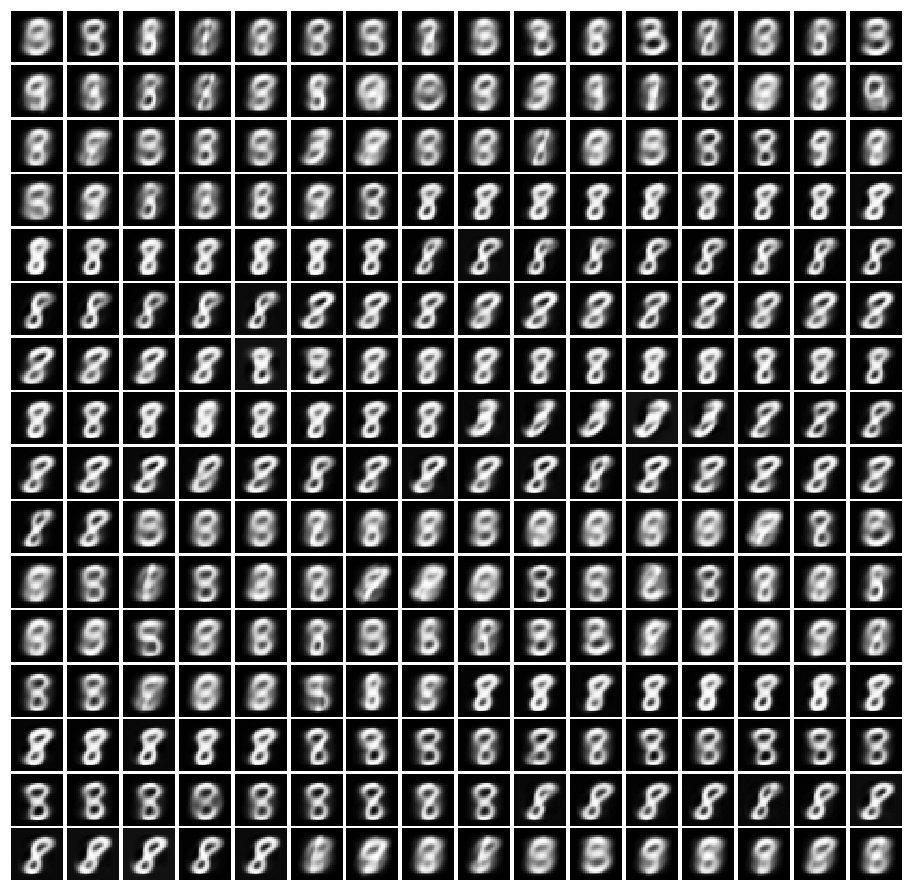

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(16, 16)
gs.update(wspace=0.05, hspace=0.05)
samples=X_train1[220000:220256,:] #highDimGen
for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    